In [96]:
import os
import re
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [97]:
%matplotlib inline

In [98]:
NAME_REGEX = r"((checkpoint|events|args).*)|(report-dev-m(?P<d>[^-]*)-(?P<s>[0-9]*)-(?P<t>train|eval|real)\.jsonl(?P<bad>\.bad)?)"

In [122]:
def table_of_accuracies(label):
    print(label)
    [logdir] = glob.glob("../logdirs/{},*".format(label))
    data = []
    for f in os.listdir(logdir):
        m = re.match(NAME_REGEX, f)
        assert m, "{} not a valid name".format(f)
        if m.group("d") is None:
            continue
        if m.group("bad"):
            continue
        data_source = m.group("t")
        data_label = m.group("d")
        checkpoint = int(m.group("s"))
        datatype = m.group("t")
        with open(os.path.join(logdir, f)) as fp:
            stats = json.loads(next(fp))
        if not stats.get('done', stats['total'] >= 2500):
            print(os.path.join(logdir, f))
            print(stats)
            continue
        
        data.append([label, checkpoint, stats['correct'] / stats['total'], data_source, data_label])
    df = pd.DataFrame(
        data, columns=['Model', 'Step', 'Accuracy', 'DataSource', 'DataLabel']
    )
    return df


In [134]:
model_labels = """
vanilla
#aggregate-standard
#aggregate-standard-slow
aggregate-with-io
#aggregate-with-io-slow
#aggregate-with-io-rnn-traces
#aggregate-with-io-graphconv-traces
#aggregate-with-io-graphconv-traces-fewer-layers
#aggregate-with-io-attention
#aggregate-with-io-attention-rnn-traces
#aggregate-with-io-graphconv-traces-labeled-edges
#aggregate-with-io-graphconv-traces-3labeled-edges
vanilla-real
vanilla-real-finetuned-slow
aggregate-with-io-real-finetuned-slow
vanilla-real-finetuned-rl-slow
aggregate-with-io-real-finetuned-rl-slow
vanilla-many-mutations
aggregate-with-io-many-mutations
vanilla-real-finetuned-rl-1e-5-very-simple
vanilla-real-finetuned-1e-4
""".strip().split("\n")
model_labels = [x for x in model_labels if x[0] != '#']

In [135]:
accuracies = [table_of_accuracies(x) for x in model_labels]
accuracies = pd.concat(accuracies)

vanilla
aggregate-with-io
vanilla-real
../logdirs/vanilla-real,data=baseline_model,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000/report-dev-m0,0,1-250100-eval.jsonl
{'total': 1024, 'correct': 109, 'syntax-error': 0, 'runtime-exception': 3, 'done': False}
vanilla-real-finetuned-slow
aggregate-with-io-real-finetuned-slow
vanilla-real-finetuned-rl-slow
aggregate-with-io-real-finetuned-rl-slow
vanilla-many-mutations
../logdirs/vanilla-many-mutations,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000,dist=1,2,3,4,5/report-dev-mgreedy,,25-400100-real.jsonl
{'total': 896, 'correct': 479, 'syntax-error': 0, 'runtime-exception': 222, 'done': False}
../logdirs/vanilla-many-mutations,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=100000,dist=1,2,3,4,5/report-dev-mgreedy,,10-450100-real.jsonl
{'total': 640, 'correct': 333, 'syntax-error': 0, 'runtime-exception': 152, 'done': False}
../logdirs/vanilla-many-mutations,trace_enc==none,batch_size==64,lr==1,lr_decay_steps=10000

In [136]:
accuracies

,Model,Step,Accuracy,DataSource,DataLabel
0,vanilla,1350100,0.564050,real,"greedy,,10"
1,vanilla,150100,0.224174,real,
2,vanilla,1650100,0.975200,eval,1
3,vanilla,900100,0.958203,train,"0,1"
4,vanilla,1250100,0.949609,train,"0,1"
...,...,...,...,...,...
19,vanilla-real-finetuned-1e-4,50100,0.292355,real,
20,vanilla-real-finetuned-1e-4,50100,0.607438,real,"greedy,,10"
21,vanilla-real-finetuned-1e-4,50100,0.900400,eval,1
22,vanilla-real-finetuned-1e-4,100100,0.309917,real,


In [137]:
max_step = accuracies.groupby(list(set(accuracies) - {'Step', 'Accuracy'})).transform(max).Step
just_max_step = accuracies[accuracies.Step == max_step]

In [138]:
def get_accuracies(model, data_source, data_label=None):
    selected_rows = (accuracies.Model == model) & (accuracies.DataSource == data_source)
    if data_label is not None:
        selected_rows &= accuracies.DataLabel == data_label
    return accuracies[selected_rows].pivot(index='Step', columns='DataLabel', values='Accuracy')
def plot_combined_accuracy(table, label):
    if not table.index.size:
        return
    cols = sorted(table.columns)
    result = sum(table[col] for col in cols) * 100 / len(cols)
    plt.plot(result, ".-", label=label)
    plt.xlabel("Step")
    plt.ylabel("Accuracy [%]")
    plt.legend()

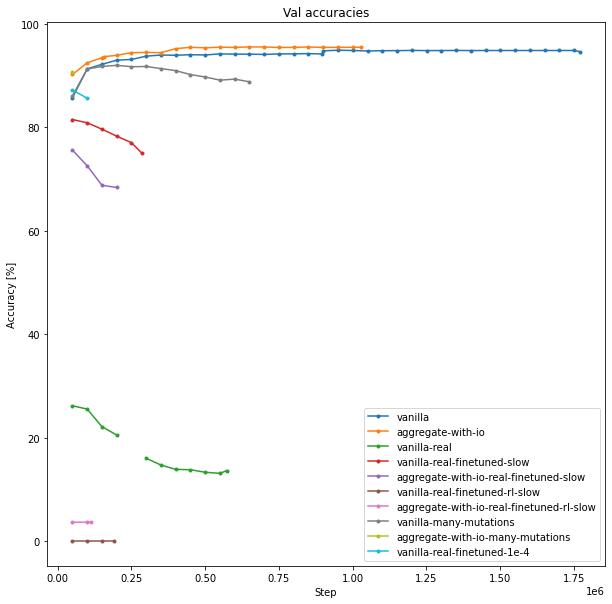

In [139]:
plt.figure(figsize=(10, 10))
plt.title("Val accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'eval'), model)

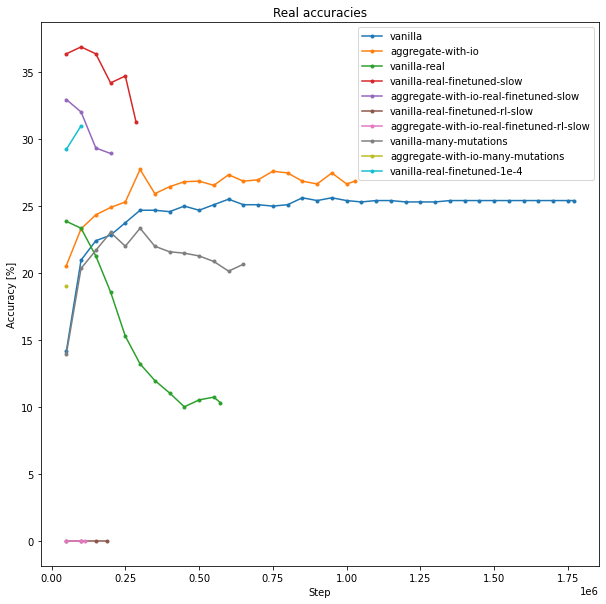

In [140]:
plt.figure(figsize=(10, 10))
plt.title("Real accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', ''), model)

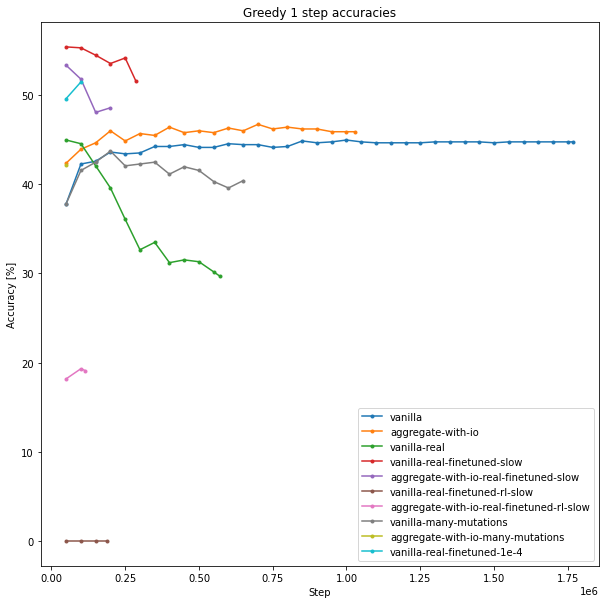

In [141]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 1 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'greedy,,1'), model)

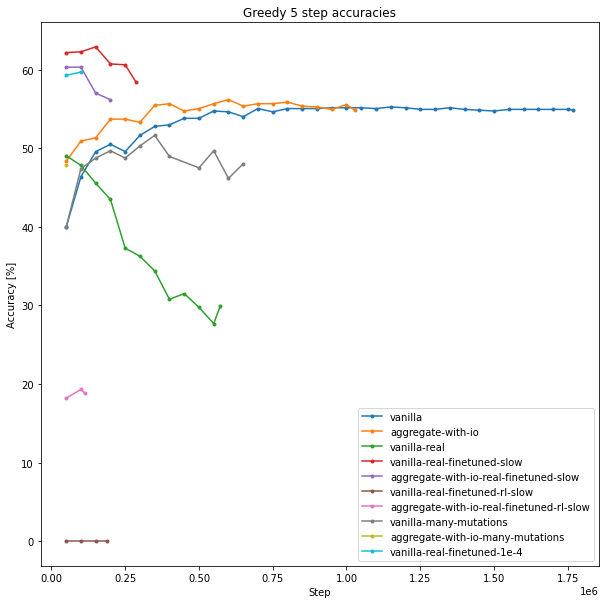

In [142]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 5 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'greedy,,5'), model)

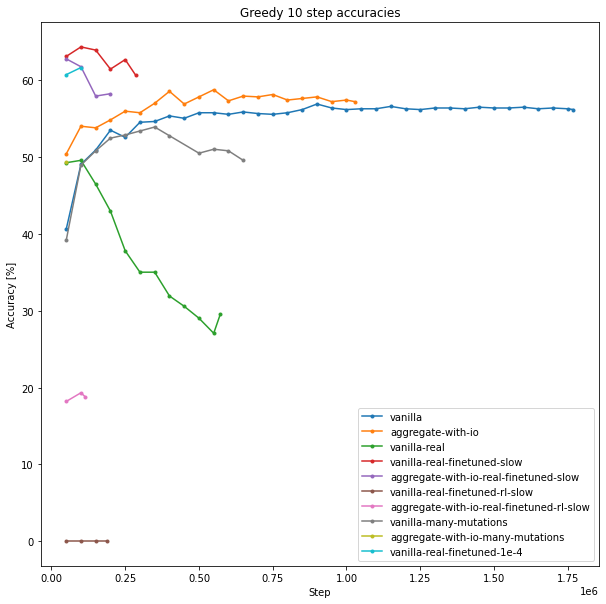

In [143]:
plt.figure(figsize=(10, 10))
plt.title("Greedy 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'greedy,,10'), model)

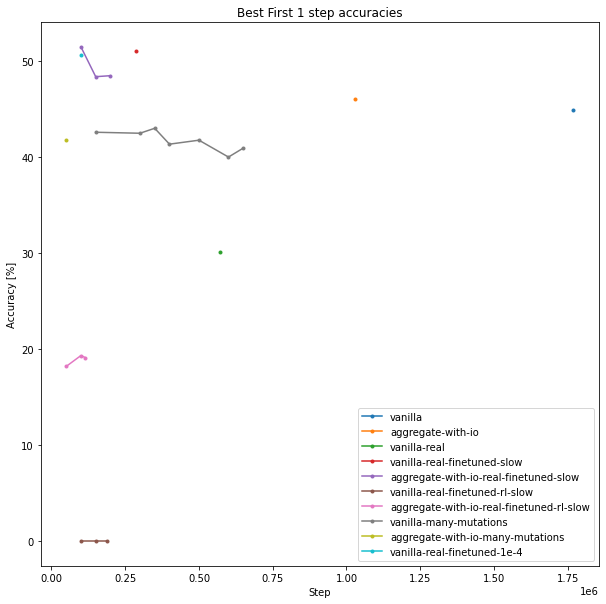

In [144]:
plt.figure(figsize=(10, 10))
plt.title("Best First 1 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'best_first,,1'), model)

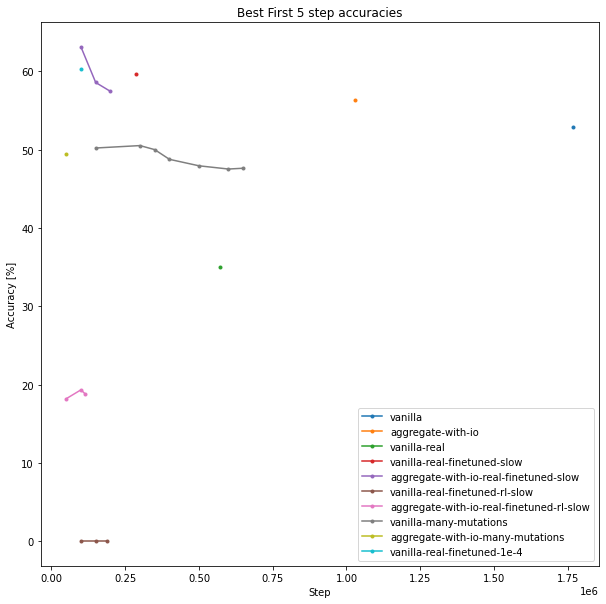

In [145]:
plt.figure(figsize=(10, 10))
plt.title("Best First 5 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'best_first,,5'), model)

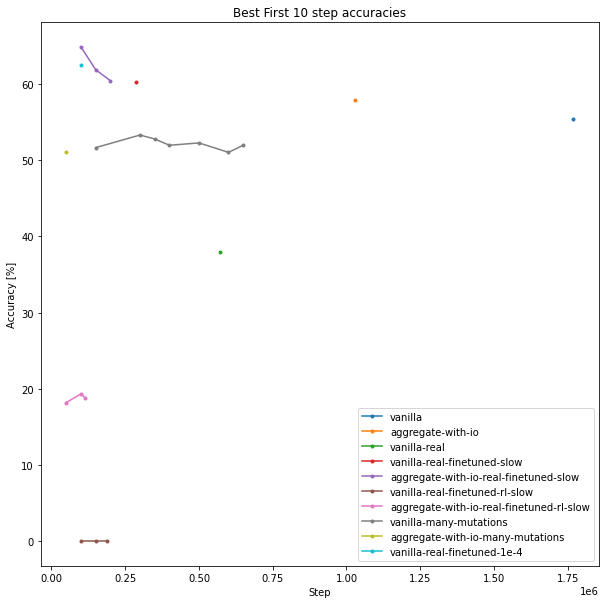

In [146]:
plt.figure(figsize=(10, 10))
plt.title("Best First 10 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'best_first,,10'), model)

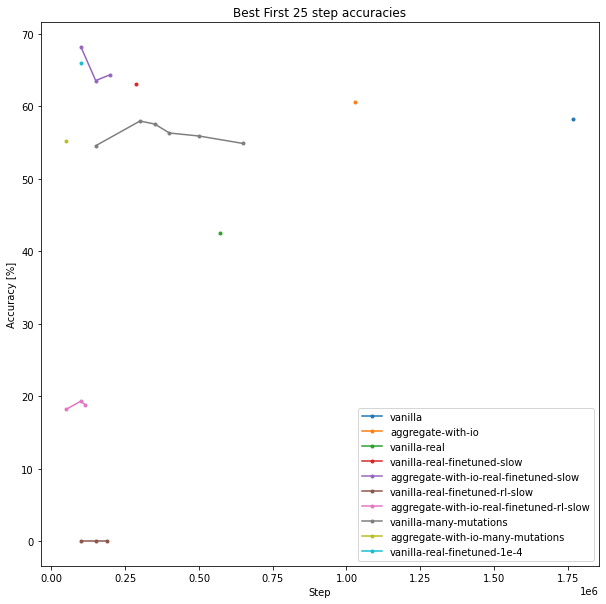

In [147]:
plt.figure(figsize=(10, 10))
plt.title("Best First 25 step accuracies")
for model in model_labels:
    plot_combined_accuracy(get_accuracies(model, 'real', 'best_first,,25'), model)

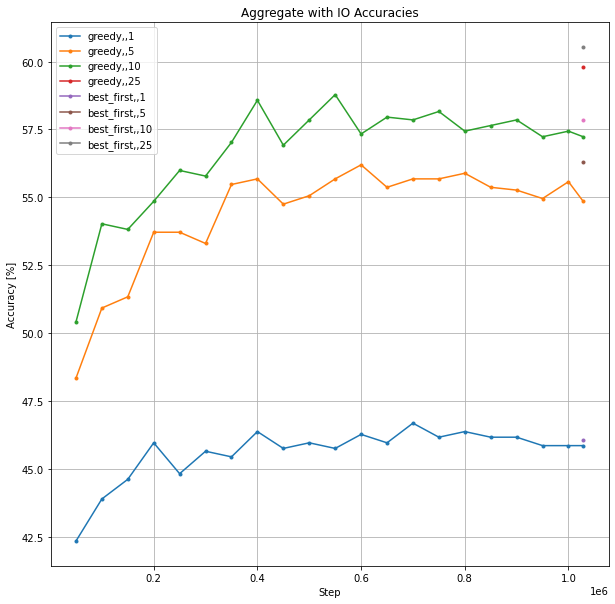

In [148]:
plt.figure(figsize=(10, 10))
plt.title("Aggregate with IO Accuracies")
for strat in "greedy", "best_first":
    for time in 1, 5, 10, 25:
        data_source = "{},,{}".format(strat, time)
        plot_combined_accuracy(get_accuracies('aggregate-with-io', 'real', data_source), data_source)
plt.grid()

In [83]:
just_max_step[
    (just_max_step.Model == 'aggregate-with-io') & (just_max_step.DataSource == 'real')
][['DataLabel', 'Accuracy']].sort_values('Accuracy')

,DataLabel,Accuracy
0,,0.268595
40,"greedy,,1",0.458678
89,"best_first,,1",0.460744
214,"greedy,,5",0.548554
209,"best_first,,5",0.563017
46,"greedy,,10",0.572314
1,"best_first,,10",0.578512
56,"greedy,,25",0.598140
172,"best_first,,25",0.605372


In [75]:
just_max_step[(just_max_step.Model == 'vanilla') & (just_max_step.DataSource == 'real')]

,Model,Step,Accuracy,DataSource,DataLabel
10,vanilla,1769300,0.584711,real,"greedy,,25"
117,vanilla,1769300,0.254132,real,
165,vanilla,1769300,0.447314,real,"greedy,,1"
223,vanilla,1769300,0.561983,real,"greedy,,10"
248,vanilla,1769300,0.448347,real,"best_first,,1"
326,vanilla,1769300,0.548554,real,"greedy,,5"
338,vanilla,1769300,0.528926,real,"best_first,,5"
339,vanilla,1769300,0.582645,real,"best_first,,25"
361,vanilla,1769300,0.553719,real,"best_first,,10"


In [76]:
just_max_step[(just_max_step.Model == 'aggregate-with-io-graphconv-traces-3labeled-edges') & (just_max_step.DataSource == 'real')]

,Model,Step,Accuracy,DataSource,DataLabel
5,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.521694,real,"greedy,,10"
13,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.523760,real,"best_first,,10"
69,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.559917,real,"best_first,,25"
131,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.220041,real,
141,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.429752,real,"greedy,,1"
163,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.539256,real,"greedy,,25"
230,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.428719,real,"best_first,,1"
269,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.501033,real,"best_first,,5"
292,aggregate-with-io-graphconv-traces-3labeled-edges,1858200,0.491736,real,"greedy,,5"


In [86]:
just_max_step[
    (just_max_step.Model == 'vanilla-real-finetuned-slow') & (just_max_step.DataSource == 'real')
][['DataLabel', 'Accuracy']].sort_values('Accuracy')

,DataLabel,Accuracy
57,,0.313017
19,"best_first,,1",0.510331
55,"greedy,,1",0.515496
1,"greedy,,5",0.584711
59,"best_first,,5",0.596074
13,"best_first,,10",0.603306
45,"greedy,,10",0.606405
24,"greedy,,25",0.607438
44,"best_first,,25",0.631198


In [90]:
accuracies[
    (accuracies.Model == 'aggregate-with-io-real-finetuned-slow') & (accuracies.DataSource == 'real') & (accuracies.Step == 100100)
][['DataLabel', 'Accuracy']].sort_values('Accuracy')

,DataLabel,Accuracy
37,,0.320248
12,"best_first,,1",0.514463
28,"greedy,,1",0.517562
14,"greedy,,5",0.603306
20,"greedy,,10",0.617769
27,"best_first,,5",0.631198
10,"greedy,,25",0.648760
38,"best_first,,10",0.648760
1,"best_first,,25",0.681818


In [78]:
just_max_step[(just_max_step.Model == 'vanilla-real') & (just_max_step.DataSource == 'real')]

,Model,Step,Accuracy,DataSource,DataLabel
30,vanilla-real,572400,0.299587,real,"greedy,,5"
40,vanilla-real,572400,0.295455,real,"greedy,,10"
61,vanilla-real,572400,0.283058,real,"greedy,,25"
64,vanilla-real,572400,0.103306,real,
77,vanilla-real,572400,0.424587,real,"best_first,,25"
78,vanilla-real,572400,0.380165,real,"best_first,,10"
86,vanilla-real,572400,0.296488,real,"greedy,,1"
109,vanilla-real,572400,0.300620,real,"best_first,,1"
116,vanilla-real,572400,0.350207,real,"best_first,,5"


In [149]:
accuracies[(accuracies.DataSource == 'real')].sort_values('Accuracy')

,Model,Step,Accuracy,DataSource,DataLabel
34,vanilla-real-finetuned-rl-slow,150100,0.000000,real,"best_first,,1"
26,vanilla-real-finetuned-rl-slow,50100,0.000000,real,"greedy,,1"
27,vanilla-real-finetuned-rl-slow,100100,0.000000,real,"greedy,,10"
25,aggregate-with-io-real-finetuned-rl-slow,114200,0.000000,real,
28,vanilla-real-finetuned-rl-slow,189400,0.000000,real,
...,...,...,...,...,...
28,aggregate-with-io-real-finetuned-slow,200100,0.643595,real,"best_first,,25"
16,aggregate-with-io-real-finetuned-slow,100100,0.648760,real,"greedy,,25"
52,aggregate-with-io-real-finetuned-slow,100100,0.648760,real,"best_first,,10"
0,vanilla-real-finetuned-1e-4,100100,0.659091,real,"best_first,,25"
